**Updated on:** 2022-10-23 23:10:05 CEST

This Notebook is used for cleaning the feature table, an output of metabolomics experiment, then performing some preliminary univariate and multivariate statistics analyses.

**Authors**: Abzer Kelminal (abzer.shah@uni-tuebingen.de), Francesco Russo (frru@ssi.dk), Filip Ottosson (faot@ssi.dk), Madaleine Ernst (maet@ssi.dk), Axel Walter (axel.walter@uni-tuebingen.de), Carolina Gonzalez, Judith Boldt <br>
**Input file format**: .csv files or .txt files <br>
**Outputs**: .csv files, .pdf & .svg images  <br>
**Dependencies**: pandas numpy plotly pingouin kaleido scikit-learn

---
This Notebook can be run with both Jupyter Notebook & Google Colab. To know more about how to get the Jupyter Notebook running with R code, please have a look at this document: [GitHub Link](https://github.com/Functional-Metabolomics-Lab/Jupyter-Notebook-Installation/blob/main/Anaconda%20with%20R%20kernel%20installation.pdf)

---
**Before starting to run this notebook with your own data, remember to save a copy of this notebook in your own Google Drive! Do so by clicking on File --> Save a copy in Drive. You can give whatever meaningful name to your notebook.** This file should be located in a new folder of your Google Drive named 'Colab Notebooks'. You can also download this notebook: File --> Download --> Download .ipynb.<br>

---
<b><font size=3> SPECIAL NOTE: Please read the comments before proceeding with the code and let us know if you run into any errors and if you think it could be commented better. We would highly appreciate your suggestions and comments!!</font> </b>

---

# **About the Data**

The files used in this tutorial are part of an interlab comparison study, where different laboratories around the world analysed the same environmental samples on their respective LC-MS/MS equipments. To simulate algal bloom, standardized algae extracts (A) in marine dissovled organic matter (M) at different concentrations were prepared (450 (A45M); 150 (A15M); and 50 (A5M) ppm A). Samples were then shipped to different laboratories for untargeted LC-MS/MS metabolomics analysis. The data used particularly for this notebook is from Lab 1 (Dorrestein Lab, University of California at San Diego, USA; Data submitted by Allegra Aron allegra.aron@gmail.com ) <br><br>
(*To be edited*) In this tutorial, we are working with one of the datasets, which was acquired on a UHPLC system coupled to a Thermo Scientific Q Exactive HF Orbitrap LC-MS/MS mass spectrometer. MS/MS data were acquired in data-dependent acquisition (DDA) with fragmentation of the five most abundant ions in the spectrum per precursor scan. Data files were subsequently preprocessed using [MZmine3](http://mzmine.github.io/) and the [feature-based molecular networking workflow in GNPS](https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=d207c3a831264d61810ad69ac09b14e9).

# **About the different sections in the Notebook:**
### **1. Data-cleaning**

It involves cleaning the feature table, which contains all the features (metabolites, in our case) with their corresponding intensities. The data cleanup steps involved are: 1) Blank removal 2) Imputation 3) Normalisation. Each step would be discussed in detail later. Once the data is cleaned, we can then use it for further statistical analyses.

### **2. Univariate statistical analysis**

Here, we will use univariate statistical methods, such as ANOVA, to investigate whether there are differences in the levels of individual features between different time points in the dataset.

### **3. Unsupervised multivariate analyses:**
#### **i. PCoA and PERMANOVA**
Here, we will perform a Principal Coordinate Analysis (PCoA), also known as metric or classical Multidimensional Scaling (metric MDS) to explore and visualize patterns in an untargeted mass spectromtery-based metabolomics dataset. We will then assess statistical significance of the patterns and dispersion of different sample types using permutational multivariate analysis of variance (PERMANOVA).

#### **ii. Cluster Analyses and Heatmaps**
We will also perform different cluster analyses to explore patterns in the data. This will help us to discover subgroups of samples or features that share a certain level of similarity. Clustering is an example of unsupervised learning where no labels are given to the learning algorithm which will try to find patterns/structures in the input data on its own. The goal of clustering is to find these hidden patterns.<br>

Some types of cluster analyses (e.g. hierarchical clustering) are often associated with heatmaps. Heatmaps are a visual representation of the data where columns are usually samples and rows are features (in our case, different metabolic features). The color scale of heatmaps indicates higher or lower intensity (for instance, blue is lower and red is higher intensity).<br>

There are a lot of good videos and resources out there explaining very well the principle behind clustering. Some good ones are the following:<br>
- Hierarchical clustering and heatmaps: https://www.youtube.com/watch?v=7xHsRkOdVwo<br>
- K-means clustering: https://www.youtube.com/watch?v=4b5d3muPQmA

# **Questions to be asked in the Statistical analysis sections**: </br>
**Univariate Statistical analysis:**
*   Are metabolite levels dependent on the dilution?
*   How does the affected metabolite change throughout the dilution series?
*   How large are the differences? 
---
**Unsupervised multivariate analyses: PCoA & PERMANOVA**
*   Can we monitor algal bloom by looking at metabolomic profiles of marine dissolved organic matter?
---
**Cluster analysis and Heatmaps**
- Can we monitor algal bloom by looking at metabolomic profiles of marine dissolved organic matter?
- Are we able to group/cluster together samples derived from different concentrations of algae extracts using metabolic profiles? <br>
- Which samples are the most similar? <br>
- Are there any patterns defining the groups/clusters? That is, which features cluster together? 

# **Package installation:**
Since we are running the notebook via Colab environment which runs completely in cloud, we need to install the packages every time we run the notebook.This might take some time to install all these packages. In case you are running the notebook directly via Jupyter Notebook IDE, you need to install the packages only once.

In [ ]:
# Install libraries that are not preinstalled
!pip install pandas numpy plotly scikit-learn pingouin kaleido ipyfilechooser

In [98]:
# importing necessary modules
import pandas as pd
import numpy as np
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import scale
import pingouin as pg
from ipyfilechooser import FileChooser
from ipywidgets import interact
import warnings

In [96]:
# Disable warnings for cleaner output, comment out for debugging
warnings.filterwarnings('ignore')

# **Setting a local working directory:**
### For Google Colab Users:
<p style='text-align: justify;'> <font color='red'>For Google Colab, it is not possible to access the files from your local computer as it is hosted on Google's cloud server. An easier workaround is to upload the necessary files into the Google colab session using the 'Files' icon on the left as shown in the image. The code in the next cell creates a new folder 'My_TestData' in the Colab space and sets the folder as working directory. Following the steps in the image, you can check in your Colab to see if the folder has been created. Once you see it, simply upload the files from your local PC to the folder 'My_TestData' and then continue running the rest of the script.</font> </p>

<p style='text-align: justify;'><b>SPECIAL NOTE: All the files uploaded to Google Colab would generally disappear after 12 hours. Similarly, all the outputs would be saved only in the Colab, so we need to download them into our local system at the end of our session.</b></p> 

[Go to section: Getting outputs from Colab](#colab_output) 

**Importing files into Google Colab environment:**
![Google-Colab Files Upload](https://github.com/abzer005/Images-for-Jupyter-Notebooks/blob/main/StepsAll.png?raw=true)

In [9]:
# Get folder with data files
result_dir = input("Enter path to folder for your results (or leave empty to stay in this folder):\n")
if not result_dir:
    result_dir = "."
if not os.path.exists(result_dir):
    os.mkdir(result_dir)
print(f"Results folder is: {os.path.abspath(result_dir)}")

Enter path to folder for your results (or leave empty to stay in this folder):
 results


Results folder is: /home/axel/dev/Statistical-analysis-of-non-targeted-LC-MSMS-data/Python_Notebooks/results


**For users running the script directly in Jupyter Notebook instead through Google Colab**, please make sure to include all the input files in one folder before running the script. Then for setting the working directory, use the below code on a new cell. When you run the cell, it will display an output box where you can enter the path of the folder containing all your input files in your local computer and it will set as your working directory<br> For ex: D:\User\Project\Test_Data

```
directory = input("Enter the path of the folder with input files:\n")
os.chdir(directory)
```



# **Input files needed for the Notebook:**
1) <b>Feature table:</b> An output of metabolomics experiment, containing all the features or peaks (LC-MS/MS peaks here) with their corresponding intensities. The feature table used in the test data is obtained by MZmine3. (Filetype: .csv file) </br> 
2) <b>Metadata:</b> Created by the user about the files used obtaining the feature table (It can be a csv/txt/tsv file). The columns in a metadata should be created with the following format: filename (1st column having all the filenames in the same order as the columns in feature table), all the other columns with column name such as: ATTRIBUTE_yourDesiredAttribute. </br>

Please have a look at the metadata used here for reference. Creating a metadata in the above-mentioned format is necessary for uploading the files in GNPS and to obtain a molecular network.

## Reading the input data using URL:
Here, we can directly pull the data files from our Functional Metabolomics GitHub page (and skip the next three cells):

In [10]:
#Reading the input data using URL 
ft_url = 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Statistical-analysis-of-non-targeted-LC-MSMS-data/main/Data/Lab_1_data/Lab1_GNPS_file_quant.csv'
md_url = 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Statistical-analysis-of-non-targeted-LC-MSMS-data/main/Data/Lab_1_data/metadata_dom_interlab_lab1.txt'

ft = pd.read_csv(ft_url)
md = pd.read_csv(md_url, sep = "\t").set_index("filename")

Or you can select local files:

In [24]:
fc_feature = FileChooser()
print("Select a feature quantification file: ")
display(fc_feature)

Select a feature quantification file: 


FileChooser(path='/home/axel/dev/Statistical-analysis-of-non-targeted-LC-MSMS-data/Python_Notebooks', filename…

In [25]:
fc_meta = FileChooser()
print("Select a meta value file: ")
display(fc_meta)

Select a meta value file: 


FileChooser(path='/home/axel/dev/Statistical-analysis-of-non-targeted-LC-MSMS-data/Python_Notebooks', filename…

In [26]:
# define separators for different input file formats
separators = {"csv": ",", "tsv": "\t", "txt": "\t"}

# read feature table
file = fc_feature.selected
if file:
    ft = pd.read_csv(file, sep = separators[file.split(".")[-1]])
else:
    print("Please select a feature file and rerun this cell.")
# read metadata table
file = fc_meta.selected
if file:
    md = pd.read_csv(file, sep = separators[file.split(".")[-1]]).set_index("filename")
else:
    print("Please select a metavalue file and rerun this cell.")

Let's check if the data has been read correclty!!

In [ ]:
print('Dimension: ',ft.shape) #gets the dimension (number of rows and columns) of ft
ft.head() # gets the first 5 rows of ft

Dimension:  (3726, 27)


,row ID,row m/z,row retention time,row ion mobility,row ion mobility unit,row CCS,correlation group ID,annotation network number,best ion,auto MS2 verify,...,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep2.mzML Peak area,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep1.mzML Peak area,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep2.mzML Peak area,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep1.mzML Peak area,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep2.mzML Peak area,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep3.mzML Peak area,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep3.mzML Peak area,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep3.mzML Peak area,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep3.mzML Peak area,Unnamed: 26
0,834,150.127731,1.051655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.000,0.00,0.00,0.000,0.000,0.000,0.00,0.000,NaN
1,1458,150.127832,3.193527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73032.68,89184.164,0.00,175378.06,63048.625,86292.555,69219.234,174635.88,35095.742,NaN
2,1418,150.127834,3.172659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,179107.34,182752.950,202764.25,91746.70,168632.830,182786.730,170407.940,100635.78,190752.250,NaN
3,30,151.035229,0.653155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,245133.69,249818.030,227996.84,223716.30,221928.160,250871.080,245521.730,261982.14,244421.440,NaN
4,991,151.035334,1.312131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.000,0.00,0.00,0.000,0.000,0.000,0.00,0.000,NaN


In [ ]:
print('Dimension: ',md.shape)
md.head()

Dimension:  (13, 3)


,ATTRIBUTE_Sample,ATTRIBUTE_Sample_Type,ATTRIBUTE_Time-Point
filename,,,
DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep1.mzML,A5M,Sample,5.0
DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep2.mzML,A5M,Sample,5.0
DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep3.mzML,A5M,Sample,5.0
DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep1.mzML,A15M,Sample,15.0
DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep2.mzML,A15M,Sample,15.0


## **Creating Functions:**
<p style='text-align: justify;'> Before getting into the Data cleanup steps, we have created a function that can be used later for data summarization. By creating functions, we don't have to write these big codes multiple times. Instead, we just use the function name. <font color="red">The following cell in this section will not produce any outputs here. </font> The outputs will be produced when we give input variables to the function in the later sections. </p>

<p style='text-align: justify;'> Using this function InsideLevels, we get an idea of the multiple levels in each of the metioned attributes in the metadata as well as the datatype of each attribute.  <font color ="blue"> This function takes metadata table as its input. </font></p>

In [27]:
def inside_levels(df):
    # get all the columns (equals all attributes) -> will be number of rows
    levels = []
    types = []
    count = []
    for col in df.columns:
        types.append(type(df[col][0]))
        levels.append(sorted(set(df[col].dropna())))
        tmp = df[col].value_counts()
        count.append([tmp[levels[-1][i]] for i in range(len(levels[-1]))])
    return pd.DataFrame({"ATTRIBUTES": df.columns, "LEVELS": levels, "COUNT":count, "TYPES": types}, index=range(1, len(levels)+1))

First, let's have a look at the different conditions within each attribute of our metadata.

In [28]:
inside_levels(md)

,ATTRIBUTES,LEVELS,COUNT,TYPES
1,ATTRIBUTE_Sample,"[A15M, A45M, A5M, M, PPL]","[3, 3, 3, 3, 1]",<class 'str'>
2,ATTRIBUTE_Sample_Type,"[Process_Blank, Sample]","[1, 12]",<class 'str'>
3,ATTRIBUTE_Time-Point,"[0.0, 5.0, 15.0, 45.0]","[3, 3, 3, 3]",<class 'numpy.float64'>


The above table is a summary of our metadata tabel. For example, the 1st row says that there are 5 different types of sample under 'ATTRIBUTE_Sample' category namely A15M,A45M,A5M,M,PPL and the count of each of these types is 3,3,3,1.

# **Arranging metadata and feature table in the same order:**

<p style='text-align: justify;'> In the next cell, we are trying to bring the feature table and metadata in the correct format such as <font color ="green"> the rownames of metadata and column names of feature table are the same. </font> They both are the file names and they need to be the same, as from now on, we will call the columns in our feature table based on our metadata information. Thus, using the metadata, the user can filter their data easily. You can also directly deal with your feature table without metadata by getting your hands dirty with some coding!! But having a metadata improves the user-experience greatly. </p>

In [29]:
# structure of the original metadata file
md.head()

,ATTRIBUTE_Sample,ATTRIBUTE_Sample_Type,ATTRIBUTE_Time-Point
filename,,,
DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep1.mzML,A5M,Sample,5.0
DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep2.mzML,A5M,Sample,5.0
DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep3.mzML,A5M,Sample,5.0
DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep1.mzML,A15M,Sample,15.0
DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep2.mzML,A15M,Sample,15.0


In [32]:
new_md = md.copy() #storing the files under different names to preserve the original files
# remove the (front & tail) spaces, if any present, from the rownames of md
new_md.index = [name.strip() for name in md.index]
# for each col in new_md
# 1) removing the spaces (if any)
# 2) replace the spaces (in the middle) to underscore
# 3) converting them all to UPPERCASE
for col in new_md.columns:
    if new_md[col].dtype == str:
        new_md[col] = [item.strip().replace(" ", "_").upper() for item in new_md[col]]
print('Dimension: ',new_md.shape)
new_md.head()

Dimension:  (13, 3)


,ATTRIBUTE_Sample,ATTRIBUTE_Sample_Type,ATTRIBUTE_Time-Point
DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep1.mzML,A5M,Sample,5.0
DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep2.mzML,A5M,Sample,5.0
DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep3.mzML,A5M,Sample,5.0
DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep1.mzML,A15M,Sample,15.0
DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep2.mzML,A15M,Sample,15.0


In [33]:
# structure of the original feature file
ft.head()

,row ID,row m/z,row retention time,row ion mobility,row ion mobility unit,row CCS,correlation group ID,annotation network number,best ion,auto MS2 verify,...,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep2.mzML Peak area,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep1.mzML Peak area,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep2.mzML Peak area,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep1.mzML Peak area,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep2.mzML Peak area,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep3.mzML Peak area,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep3.mzML Peak area,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep3.mzML Peak area,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep3.mzML Peak area,Unnamed: 26
0,834,150.127731,1.051655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.000,0.00,0.00,0.000,0.000,0.000,0.00,0.000,NaN
1,1458,150.127832,3.193527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73032.68,89184.164,0.00,175378.06,63048.625,86292.555,69219.234,174635.88,35095.742,NaN
2,1418,150.127834,3.172659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,179107.34,182752.950,202764.25,91746.70,168632.830,182786.730,170407.940,100635.78,190752.250,NaN
3,30,151.035229,0.653155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,245133.69,249818.030,227996.84,223716.30,221928.160,250871.080,245521.730,261982.14,244421.440,NaN
4,991,151.035334,1.312131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.000,0.00,0.00,0.000,0.000,0.000,0.00,0.000,NaN


In [34]:
new_ft = ft.copy() #storing the files under different names to preserve the original files
# changing the index in feature table to contain m/z and RT information
new_ft.index = [f"{id}_{round(mz, 3)}_{round(rt, 3)}" for id, mz, rt in zip(ft["row ID"], ft["row m/z"], ft["row retention time"])]
# drop all columns that are not mzML or mzXML file names
new_ft.drop(columns=[col for col in new_ft.columns if ".mz" not in col], inplace=True)
# remove " Peak area" from column names
new_ft.rename(columns={col: col.replace(" Peak area", "").strip() for col in new_ft.columns}, inplace=True)
print('Dimension: ',new_ft.shape)
new_ft.head()

Dimension:  (3726, 13)


,DOM_Interlab-LCMS_Lab1_PPL_blank_Pos_MS2.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep3.mzML
834_150.128_1.052,81619.78,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.000,0.000,0.00,0.000
1458_150.128_3.194,0.00,160484.12,90376.305,76711.62,73032.68,89184.164,0.00,175378.06,63048.625,86292.555,69219.234,174635.88,35095.742
1418_150.128_3.173,0.00,0.00,180862.780,155348.86,179107.34,182752.950,202764.25,91746.70,168632.830,182786.730,170407.940,100635.78,190752.250
30_151.035_0.653,0.00,227419.23,234767.060,216268.95,245133.69,249818.030,227996.84,223716.30,221928.160,250871.080,245521.730,261982.14,244421.440
991_151.035_1.312,98517.07,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.000,0.000,0.00,0.000


Checking the tables:

In [35]:
# check if new_ft column names and md row names are the same
if sorted(new_ft.columns) == sorted(new_md.index):
    print(f"All {len(new_ft.columns)} files are present in both new_md & new_ft.")
else:
    print("Not all files are present in both new_md & new_ft.\n")
    # print the md rows / ft column which are not in ft columns / md rows and remove them
    ft_cols_not_in_md = [col for col in new_ft.columns if col not in new_md.index]
    print(f"These {len(ft_cols_not_in_md)} columns of feature table are not present in metadata table and will be removed:\n{', '.join(ft_cols_not_in_md)}\n")
    new_ft.drop(columns=ft_cols_not_in_md, inplace=True)
    md_rows_not_in_ft = [row for row in new_md.index if row not in new_ft.columns]
    print(f"These {len(md_rows_not_in_ft)} rows of metadata table are not present in feature table and will be removed:\n{', '.join(md_rows_not_in_ft)}\n")
    new_md.drop(md_rows_not_in_ft, inplace=True)

All 13 files are present in both new_md & new_ft.


In [36]:
new_ft = new_ft.reindex(sorted(new_ft.columns), axis=1) #ordering the ft by its column names
new_md.sort_index(inplace=True) #ordering the md by its row names

In [37]:
# checking the dimensions of our new ft and md
print(f"The number of rows and columns in our original ft is: {ft.shape}")
print(f"The number of rows and columns in our new ft is: {new_ft.shape}")
print(f"The number of rows and columns in our original md is: {md.shape}")
print(f"The number of rows and columns in our new md is: {new_md.shape}\n")

The number of rows and columns in our original ft is: (3726, 27)
The number of rows and columns in our new ft is: (3726, 13)
The number of rows and columns in our original md is: (13, 3)
The number of rows and columns in our new md is: (13, 3)



Notice that the number of columns of feature table is same as the number of rows in our metadata. Now, we have both our feature table and metadata in the same order.

In [38]:
#checking if they the files are in the same order
list(new_ft.columns) == list(new_md.index)

True

Lets check the files once again!!

In [39]:
print('Dimension: ',new_ft.shape)
new_ft.head()

Dimension:  (3726, 13)


,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_PPL_blank_Pos_MS2.mzML
834_150.128_1.052,0.00,0.000,0.000,0.00,0.00,0.000,0.00,0.000,0.000,0.000,0.00,0.00,81619.78
1458_150.128_3.194,175378.06,63048.625,35095.742,76711.62,73032.68,86292.555,160484.12,90376.305,69219.234,89184.164,0.00,174635.88,0.00
1418_150.128_3.173,91746.70,168632.830,190752.250,155348.86,179107.34,182786.730,0.00,180862.780,170407.940,182752.950,202764.25,100635.78,0.00
30_151.035_0.653,223716.30,221928.160,244421.440,216268.95,245133.69,250871.080,227419.23,234767.060,245521.730,249818.030,227996.84,261982.14,0.00
991_151.035_1.312,0.00,0.000,0.000,0.00,0.00,0.000,0.00,0.000,0.000,0.000,0.00,0.00,98517.07


In [40]:
print('Dimension: ',new_md.shape)
new_md.head()

Dimension:  (13, 3)


,ATTRIBUTE_Sample,ATTRIBUTE_Sample_Type,ATTRIBUTE_Time-Point
DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep1.mzML,A15M,Sample,15.0
DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep2.mzML,A15M,Sample,15.0
DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep3.mzML,A15M,Sample,15.0
DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep1.mzML,A45M,Sample,45.0
DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep2.mzML,A45M,Sample,45.0


# Splitting the data into Blanks and Samples using Metadata:
<a id="data_split"></a>

For the first step: Blank removal, we need to split the data as spectra obtained from blanks and samples respectively using the metadata. More about Blank removal in the next section.

In [41]:
inside_levels(new_md)

,ATTRIBUTES,LEVELS,COUNT,TYPES
1,ATTRIBUTE_Sample,"[A15M, A45M, A5M, M, PPL]","[3, 3, 3, 3, 1]",<class 'str'>
2,ATTRIBUTE_Sample_Type,"[Process_Blank, Sample]","[1, 12]",<class 'str'>
3,ATTRIBUTE_Time-Point,"[0.0, 5.0, 15.0, 45.0]","[3, 3, 3, 3]",<class 'numpy.float64'>


In case we want to remove certain files of a particular condition, for ex: ATTRIBUTE_sample = "M", we can subset them out of our dataframe using the next cell. 

In [ ]:
# subset_data = new_md[new_md['ATTRIBUTE_Sample']!='M']
# print('Dimension: ',subset_data.shape)
# inside_levels(subset_data)

Once we subset the data, we can further proceed to split the blanks from the sample in the cell below. If no subsetting is involved, you can simply split your metadata into blank and sample.

In [44]:
#If subset_data exists, it will take it as "data", else take new_md as "data"
if 'subset_data' in locals():
    data = subset_data
else:
    data = new_md
display(inside_levels(data))

condition = int(input("Enter the index number of the attribute to split sample and blank: "))
df = pd.DataFrame({"LEVELS": inside_levels(data).iloc[condition-1]["LEVELS"]})
df.index = [*range(1, len(df)+1)]
display(df)

#Among the shown levels of an attribute, select the ones to keep
blank_id = int(input("Enter the index number of your BLANK: "))
print('Your chosen blank is: ', df['LEVELS'][blank_id])

#Splitting the data into blanks and samples based on the metadata
md_blank = data[data[inside_levels(data)['ATTRIBUTES'][condition]] == df['LEVELS'][blank_id]]
blank = new_ft[list(md_blank.index)]
md_samples = data[data[inside_levels(data)['ATTRIBUTES'][condition]] != df['LEVELS'][blank_id]]
samples = new_ft[list(md_samples.index)]

,ATTRIBUTES,LEVELS,COUNT,TYPES
1,ATTRIBUTE_Sample,"[A15M, A45M, A5M, M, PPL]","[3, 3, 3, 3, 1]",<class 'str'>
2,ATTRIBUTE_Sample_Type,"[Process_Blank, Sample]","[1, 12]",<class 'str'>
3,ATTRIBUTE_Time-Point,"[0.0, 5.0, 15.0, 45.0]","[3, 3, 3, 3]",<class 'numpy.float64'>


Enter the index number of the attribute to split sample and blank:  2


,LEVELS
1,Process_Blank
2,Sample


Enter the index number of your BLANK:  1


Your chosen blank is:  Process_Blank


In [45]:
# Display the chosen blank
print('Dimension: ',blank.shape)
blank.head()

Dimension:  (3726, 1)


,DOM_Interlab-LCMS_Lab1_PPL_blank_Pos_MS2.mzML
834_150.128_1.052,81619.78
1458_150.128_3.194,0.00
1418_150.128_3.173,0.00
30_151.035_0.653,0.00
991_151.035_1.312,98517.07


In [46]:
# Display the chosen samples
print('Dimension: ',samples.shape)
samples.head()

Dimension:  (3726, 12)


,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep3.mzML
834_150.128_1.052,0.00,0.000,0.000,0.00,0.00,0.000,0.00,0.000,0.000,0.000,0.00,0.00
1458_150.128_3.194,175378.06,63048.625,35095.742,76711.62,73032.68,86292.555,160484.12,90376.305,69219.234,89184.164,0.00,174635.88
1418_150.128_3.173,91746.70,168632.830,190752.250,155348.86,179107.34,182786.730,0.00,180862.780,170407.940,182752.950,202764.25,100635.78
30_151.035_0.653,223716.30,221928.160,244421.440,216268.95,245133.69,250871.080,227419.23,234767.060,245521.730,249818.030,227996.84,261982.14
991_151.035_1.312,0.00,0.000,0.000,0.00,0.00,0.000,0.00,0.000,0.000,0.000,0.00,0.00


**Now that we have our data ready, we can start with the cleanup steps!!**

# Step1: Blank Removal

<p style='text-align: justify;'> In LC-MS/MS, we use solvents called Blanks which are usually injected time-to-time to prevent carryover of the sample. The features coming from these Blanks would also be detected by LC-MS/MS instrument. Our goal here is to remove these features from our samples. The other blanks that can be removed are: Signals coming from growth media alone in terms of microbial growth experiment, signals from the solvent used for extraction methods and so on. Therefore, it is best practice to measure mass spectra of these blanks as well in addition to your sample spectra. </p>

**How do we remove these blank features?** </br> 
<p style='text-align: justify;'> Since we have the feature table split into Control blanks and Sample groups now, we can compare blanks to the sample to identify the background features coming from blanks. A common filtering method is to use a cutoff to remove features that are not present sufficient enough in our biological samples. </p>

The steps followed in the next few cells are:
1. <p style='text-align: justify;'> We find an average for all the feature intensities in your blank set and sample set. Therefore, for n no.of features in a blank or sample set, we get n no.of averaged features. </p>
2. <p style='text-align: justify;'> Next, we get a ratio of this average_blanks vs average_sample. This ratio Blank/sample tells us how much of that particular feature of a sample gets its contribution from blanks. If it is more than 30% (or Cutoff as 0.3), we consider the feature as noise. </p>
3. <p style='text-align: justify;'> The resultant information (if ratio > Cutoff or not) is stored in a bin such as 1 = Noise or background signal, 0 = Feature Signal</p>
4. <p style='text-align: justify;'> We count the no.of features in the bin that satisfies the condition ratio > cutoff, and consider those features as 'noise or background features' and remove them. </p>

**<font color='red'> The Cutoff used to obtain the all the files in MZmine Results folder is 0.3 </font>**

In [64]:
blank_removal = samples.copy()
if (input("Do you want to perform Blank Removal- Y/N: ").upper()=="Y"):
    
    # When cutoff is low, more noise (or background) detected; With higher cutoff, less background detected, thus more features observed
    cutoff = float(input("Enter Cutoff value between 0.1 & 1 (Ideal cutoff range: 0.1-0.3): ")) # (i.e. 10% - 100%). Ideal cutoff range: 0.1-0.3
    
    # Getting mean for every feature in blank and Samples
    avg_blank = blank.mean(axis=1, skipna=False) # set skipna = False do not exclude NA/null values when computing the result.
    avg_samples = samples.mean(axis=1, skipna=False)

    # Getting the ratio of blank vs samples
    ratio_blank_samples = (avg_blank+1)/(avg_samples+1)

    # Create an array with boolean values: True (is a real feature, ratio<cutoff) / False (is a blank, background, noise feature, ratio>cutoff)
    is_real_feature = (ratio_blank_samples<cutoff)

    # Checking if there are any NA values present. Having NA values in the 4 variables will affect the final dataset to be created
    temp_NA_Count = pd.concat([avg_blank, avg_samples, ratio_blank_samples, is_real_feature], 
                            keys=['avg_blank', 'avg_samples', 'ratio_blank_samples', 'bg_bin'], axis = 1)
    
    print('No. of NA values in the following columns: ')
    display(pd.DataFrame(temp_NA_Count.isna().sum(), columns=['NA']))

    # Calculating the number of background features and features present (sum(bg_bin) equals number of features to be removed)
    print(f"No. of Background or noise features: {len(samples)-sum(is_real_feature)}")
    print(f"No. of features after excluding noise: {sum(is_real_feature)}")

    blank_removal = samples[is_real_feature.values]
    # save to file
    blank_removal.to_csv(os.path.join(result_dir, "Blanks_Removed.csv"))

Do you want to perform Blank Removal- Y/N:  y
Enter Cutoff value between 0.1 & 1 (Ideal cutoff range: 0.1-0.3):  0.3


No. of NA values in the following columns: 


,NA
avg_blank,0
avg_samples,0
ratio_blank_samples,0
bg_bin,0


No. of Background or noise features: 123
No. of features after excluding noise: 3603


In [62]:
print('Dimension: ',blank_removal.shape)
display(blank_removal.head())

Dimension:  (3603, 12)


,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep3.mzML
1458_150.128_3.194,175378.06,63048.625,35095.742,76711.620,73032.680,86292.555,160484.120,90376.305,69219.234,89184.164,0.000,174635.88
1418_150.128_3.173,91746.70,168632.830,190752.250,155348.860,179107.340,182786.730,0.000,180862.780,170407.940,182752.950,202764.250,100635.78
30_151.035_0.653,223716.30,221928.160,244421.440,216268.950,245133.690,250871.080,227419.230,234767.060,245521.730,249818.030,227996.840,261982.14
7137_151.075_6.002,89922.16,90066.020,93198.790,44915.145,44900.082,37633.260,49160.883,65025.473,61488.168,73358.590,55780.668,74299.41
6905_151.075_5.937,101775.16,104670.170,107405.555,53007.938,51043.580,68598.516,79641.200,73830.055,80961.450,97414.860,159626.530,95220.12


# Step 2: Imputation

<p style='text-align: justify;'> For several reasons, real world datasets might have some missing values in it, in the form of NA, NANs or 0s. Eventhough the gapfilling step of MZmine fills the missing values, we still end up with some missing values or 0s in our feature table. This could be problematic for statistical analysis. </p> 
<p style='text-align: justify;'> In order to have a better dataset, we cannot simply discard those rows or columns with missing values as we will lose a chunk of our valuable data. Instead we can try imputing those missing values. Imputation involves replacing the missing values in the data with a meaningful, reasonable guess. There are several methods, such as: </p> 
  
1) Mean imputation (replacing the missing values in a column with the mean or average of the column)  
2) Replacing it with the most frequent value  
3) Several other machine learning imputation methods such as k-nearest neighbors algorithm(k-NN), Hidden Markov Model(HMM)

Here, we use ft and see the frquency distribution of its features with a plot. It shows where the features are present in higher number.

The minimum value greater than 0 in gap-filled table: 452


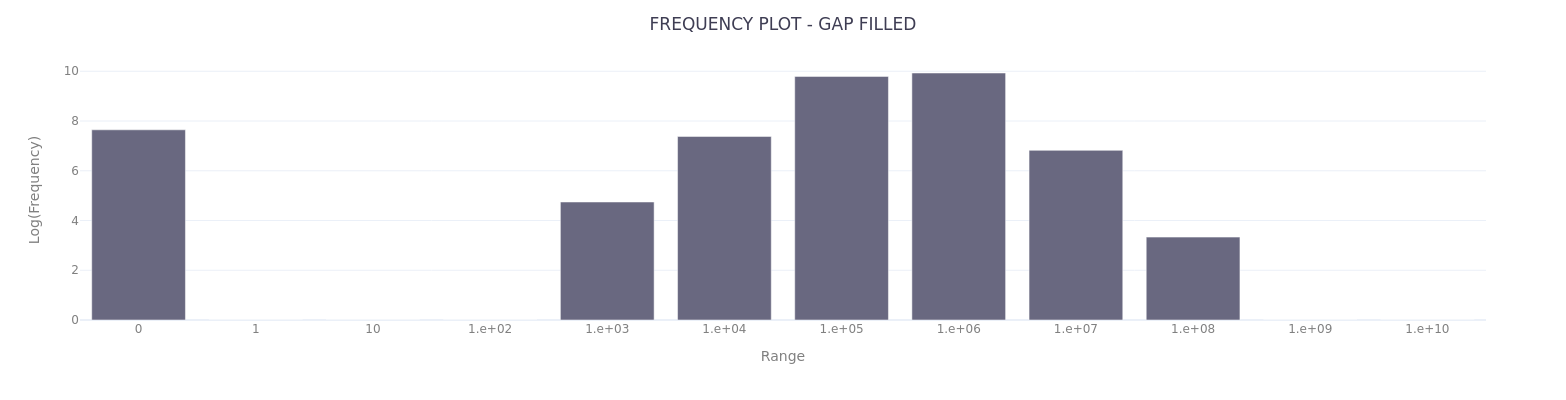

In [58]:
bins, bins_label, a = [-1, 0, 1, 10], ['-1','0', "1", "10"], 2

while a<=10:
    bins_label.append(np.format_float_scientific(10**a))
    bins.append(10**a)
    a+=1

freq_table = pd.DataFrame(bins_label)
frequency = pd.DataFrame(np.array(np.unique(np.digitize(blank_removal.to_numpy(), bins, right=True), return_counts=True)).T).set_index(0)
freq_table = pd.concat([freq_table,frequency], axis=1).fillna(0).drop(0)
freq_table.columns = ['Range', 'Frequency']
freq_table['Log(Frequency)'] = np.log(freq_table['Frequency']+1)

# get the lowest intensity (that is not zero) as a cutoff LOD value
cutoff_LOD = round(blank_removal.replace(0, np.nan).min(numeric_only=True).min())
print(f"The minimum value greater than 0 in gap-filled table: {cutoff_LOD}")

fig = px.bar(freq_table, x="Range", y="Log(Frequency)", template="plotly_white",  width=600, height=400)

fig.update_traces(marker_color="#696880")
fig.update_layout(font={"color":"grey", "size":12, "family":"Sans"},
                  title={"text":"FREQUENCY PLOT - GAP FILLED", 'x':0.5, "font_color":"#3E3D53"})

This minimum value will be used for imputation.

In [59]:
imputed = blank_removal.copy()
if(input("Do you want to perform Imputation? - Y/N: ").upper()=="Y"):
    imputed.replace(0, cutoff_LOD, inplace=True)

    print('Dimension: ',imputed.shape)
    display(imputed.head())
    # save to file
    imputed.to_csv(os.path.join(result_dir, f"Imputed_QuantTable_filled_with_{cutoff_LOD}_CutOff_Used_{cutoff}.csv"))

Do you want to perform Imputation? - Y/N:  y


Dimension:  (3603, 12)


,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep3.mzML
1458_150.128_3.194,175378.06,63048.625,35095.742,76711.620,73032.680,86292.555,160484.120,90376.305,69219.234,89184.164,452.000,174635.88
1418_150.128_3.173,91746.70,168632.830,190752.250,155348.860,179107.340,182786.730,452.000,180862.780,170407.940,182752.950,202764.250,100635.78
30_151.035_0.653,223716.30,221928.160,244421.440,216268.950,245133.690,250871.080,227419.230,234767.060,245521.730,249818.030,227996.840,261982.14
7137_151.075_6.002,89922.16,90066.020,93198.790,44915.145,44900.082,37633.260,49160.883,65025.473,61488.168,73358.590,55780.668,74299.41
6905_151.075_5.937,101775.16,104670.170,107405.555,53007.938,51043.580,68598.516,79641.200,73830.055,80961.450,97414.860,159626.530,95220.12


# Step 3:Normalization
The following code performs sample-centric (column-wise) normalisation:

In [60]:
normalized = imputed.copy()
if(input("Do you want to perform Normalization? - Y/N: ").upper()=="Y"):
    # Dividing each element of a particular column with its column sum
    normalized = normalized.apply(lambda x: x/np.sum(x), axis=0)
    
    # save to file
    normalized.to_csv(os.path.join(result_dir, "Normalised_Quant_table.csv"))
    
    print('Dimension: ', normalized.shape)
    display(normalized.head())

Do you want to perform Normalization? - Y/N:  y


Dimension:  (3603, 12)


,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab1_M_Pos_MS2_rep3.mzML
1458_150.128_3.194,0.000234,0.000082,0.000045,0.000113,0.000107,0.000125,2.606901e-04,0.000144,0.000109,0.000132,6.560964e-07,0.000248
1418_150.128_3.173,0.000122,0.000220,0.000246,0.000228,0.000263,0.000266,7.342280e-07,0.000289,0.000269,0.000270,2.943206e-04,0.000143
30_151.035_0.653,0.000298,0.000290,0.000316,0.000317,0.000360,0.000365,3.694194e-04,0.000375,0.000387,0.000369,3.309467e-04,0.000372
7137_151.075_6.002,0.000120,0.000118,0.000120,0.000066,0.000066,0.000055,7.985685e-05,0.000104,0.000097,0.000108,8.096791e-05,0.000106
6905_151.075_5.937,0.000136,0.000137,0.000139,0.000078,0.000075,0.000100,1.293690e-04,0.000118,0.000128,0.000144,2.317044e-04,0.000135


All the result files would be available in the 'Result' folder within your working directory (i.e the folder path you mentioned in the beginning of the script).

# Scaling:

In [65]:
# transposing the imputed table
imputed_t = imputed.T
print(f'Imputed feature table rows/columns: {imputed_t.shape}')
display(imputed_t.head(3))

Imputed feature table rows/columns: (12, 3603)


,1458_150.128_3.194,1418_150.128_3.173,30_151.035_0.653,7137_151.075_6.002,6905_151.075_5.937,5684_151.075_5.554,4120_151.075_5.025,1306_152.071_2.961,5858_153.055_5.605,2550_153.091_4.247,...,90_770.851_0.705,16880_774.609_12.932,16869_776.625_12.233,14833_782.541_9.242,16914_808.525_14.316,16922_810.54_14.323,16913_824.52_14.314,86_838.838_0.705,16935_852.551_14.321,80_906.826_0.705
DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep1.mzML,175378.060,91746.70,223716.30,89922.16,101775.160,136473.770,88457.305,44434.566,101986.050,243354.62,...,312315.88,32034.752,452.0000,9194.2190,452.0,58725.9260,452.0,277251.00,452.000,188810.81
DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep2.mzML,63048.625,168632.83,221928.16,90066.02,104670.170,121630.620,114447.000,35286.812,122665.555,272245.22,...,310084.20,9962.192,106560.5200,6465.1157,452.0,2024.8458,452.0,254615.38,22432.346,163156.11
DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep3.mzML,35095.742,190752.25,244421.44,93198.79,107405.555,117858.125,96552.414,32521.877,97803.620,258793.38,...,307139.22,20559.703,2871.6553,9163.6950,452.0,55433.6450,452.0,267821.97,21419.793,163915.33


In [66]:
# put the rows in the feature table and metadata in the same order
imputed_t.sort_index(inplace=True)
md_samples.sort_index(inplace=True)
try:
    print(md_samples.index == imputed_t.index) # should be all True
except:
    print("WARNING: Sample names in feature and metadata table are NOT the same!")

[ True  True  True  True  True  True  True  True  True  True  True  True]


# Univariate:

Too many missing values is problematic for statistical analyses. Here we calculate the proportion of missing values (coded as the value of the cutoff_LOD) and display the proportions in a histogram

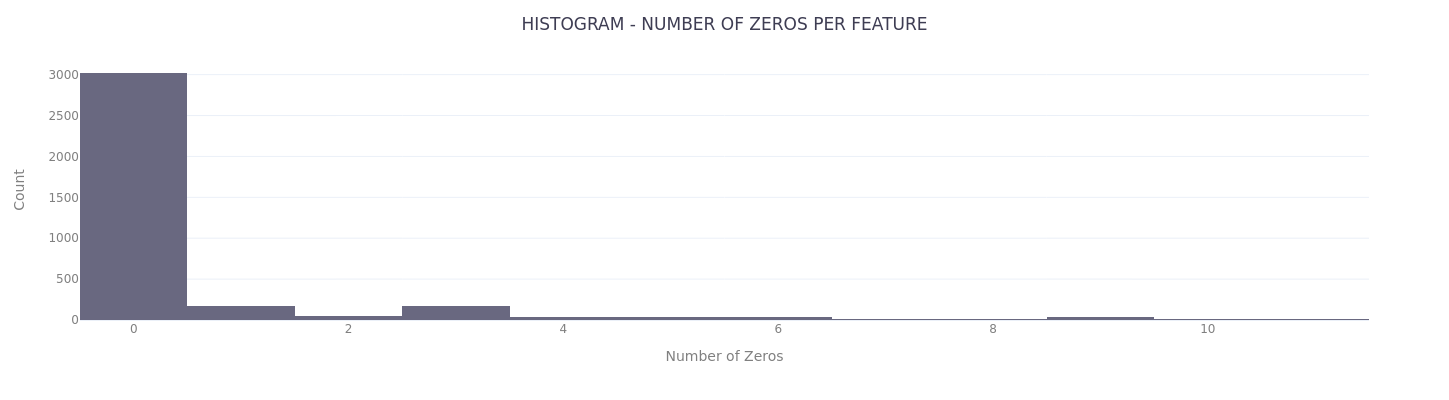

In [70]:
n_zeros = imputed_t.apply(lambda x: sum(x==cutoff_LOD))

fig = px.histogram(n_zeros, template="plotly_white",  
                   width=600, height=400)

fig.update_traces(marker_color="#696880")
fig.update_layout(font={"color":"grey", "size":12, "family":"Sans"},
                  title={"text":"HISTOGRAM - NUMBER OF ZEROS PER FEATURE", 'x':0.5, "font_color":"#3E3D53"},
                  xaxis_title="Number of Zeros", yaxis_title="Count", showlegend=False)

In [71]:
print(f"Proportion of the dataset that consists of missing values (coded as {cutoff_LOD}): {((imputed_t==cutoff_LOD).to_numpy()).mean()}")
print(f"\nMetabolites with measurements (non {cutoff_LOD}) in at least 50 % of the samples: {(((n_zeros/imputed_t.shape[0])<=0.5).to_numpy()).mean()}")

Proportion of the dataset that consists of missing values (coded as 452): 0.04840873346285503

Metabolites with measurements (non 452) in at least 50 % of the samples: 0.9758534554537885


Deselect metabolites with more than 50 % missing values. This helps to get rid of features that are present in too few samples to conduct proper statistical tests

In [72]:
data_filtered = imputed_t[imputed_t.columns[(n_zeros/imputed_t.shape[0])<0.5]]

# scale filtered data
data_scaled = pd.DataFrame(scale(data_filtered), index=data_filtered.index, columns=data_filtered.columns)

# Merge feature table and metadata to one dataframe:
# "how=inner" performs an inner join (only the filenames that appear in md_samples and data are kept)
data = pd.merge(md_samples, data_scaled, left_index=True, right_index=True, how="inner")

display(data.head())

,ATTRIBUTE_Sample,ATTRIBUTE_Sample_Type,ATTRIBUTE_Time-Point,1458_150.128_3.194,1418_150.128_3.173,30_151.035_0.653,7137_151.075_6.002,6905_151.075_5.937,5684_151.075_5.554,4120_151.075_5.025,...,16269_736.485_10.53,16267_741.44_10.53,16931_744.42_14.322,16868_748.593_12.237,90_770.851_0.705,14833_782.541_9.242,16922_810.54_14.323,86_838.838_0.705,16935_852.551_14.321,80_906.826_0.705
DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep1.mzML,A15M,Sample,15.0,1.628980,-1.053124,-1.020978,1.348525,0.441509,1.651623,0.187444,...,-0.547433,-0.564515,0.028618,2.084233,-0.485050,-0.527895,0.433955,-0.174226,-0.549442,0.320186
DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep2.mzML,A15M,Sample,15.0,-0.543722,0.324533,-1.153552,1.356302,0.545070,1.140705,1.376215,...,-0.515986,-0.500457,0.143200,1.331740,-0.578428,-0.570459,-0.623779,-1.231997,-0.028349,-1.252695
DOM_Interlab-LCMS_Lab1_A15M_Pos_MS2_rep3.mzML,A15M,Sample,15.0,-1.084394,0.720872,0.514123,1.525673,0.642921,1.010851,0.557715,...,-0.554693,-0.526866,0.202400,1.688222,-0.701652,-0.528371,0.372539,-0.614848,-0.052354,-1.206147
DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep1.mzML,A45M,Sample,45.0,-0.279449,0.086509,-1.573132,-1.084736,-1.303003,-1.453874,-1.704643,...,2.084470,1.384126,1.738273,-0.242834,1.379181,1.974547,2.214279,1.146465,-0.549442,1.326451
DOM_Interlab-LCMS_Lab1_A45M_Pos_MS2_rep2.mzML,A45M,Sample,45.0,-0.350608,0.512217,0.566929,-1.085550,-1.373272,-1.520887,-1.818895,...,1.887457,1.888792,1.453006,-0.571682,0.500670,1.663683,-0.609766,0.334642,2.668665,0.081857


**Run ANOVA** <br>

We now use the function anova from the pingouin library to run the ANOVA. Since one ANOVA is being run for each metabolite feature, we run the analyses in a loop and save the output for each feature in a list called anova_out.<br>

The vector a indicates which columns in the dataset are features (i.e. from column 5 to the last column of the data frame). <br>

We can run a for loop to pass each feature column into the first argument of the aov function, while the second argument, time point, is constant.

In [73]:
def gen_anova_data(df, columns, groups_col):
    for col in columns:
        result = pg.anova(data=df, dv=col, between=groups_col, detailed=True).set_index('Source')
        p = result.loc[groups_col, 'p-unc']
        f = result.loc[groups_col, 'F']
        yield col, p, f

dtypes = [('metabolite', 'U100'), ('p', 'f'), ('F', 'f')]
anova = pd.DataFrame(np.fromiter(gen_anova_data(data, data_scaled.columns, 'ATTRIBUTE_Time-Point'), dtype=dtypes))

The following is of interest:
*   Feature ID (column 'metabolite')
*   p-value for ANOVA
*   p-value after taking multiple tests into consideration
*   F-value

In [ ]:
# add Bonferroni corrected p-values for multiple testing correction
anova.insert(2, 'p_bonferroni', pg.multicomp(anova['p'], method='bonf')[1])
# add significance
anova.insert(3, 'significant', anova['p_bonferroni'] < 0.05)
# sort by p-value
anova.sort_values('p', inplace=True)
# save ANOVA table
anova.to_csv(os.path.join(result_dir, 'ANOVA_results.csv'))
display(anova.head(20))

**Plot ANOVA results**

We will use plotly to visualize results from the ANOVA, with log(F-values) on the x-axis and -log(p) on the y-axis. Features are colored after statistical significance after multiple test correction. Since there are large differences in the F- and p-values, it is easier to plot their log.

We can also display the names of some of the top features in the plot. This easily gets very cluttered if we decide to display too many names, so starting at the top 5 could be a good idea.

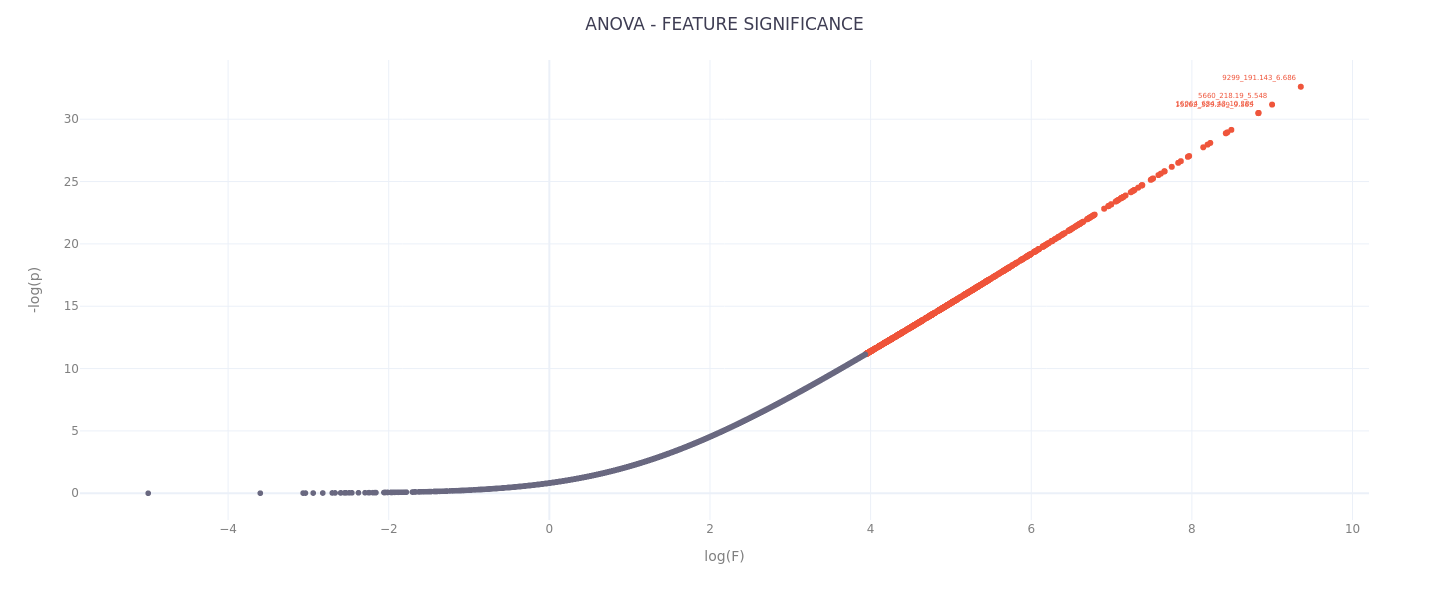

In [118]:
# first plot insignificant features
fig = px.scatter(x=anova[anova['significant'] == False]['F'].apply(np.log),
                y=anova[anova['significant'] == False]['p'].apply(lambda x: -np.log(x)),
                template='plotly_white', width=600, height=600)
fig.update_traces(marker_color="#696880")

# plot significant features
fig.add_scatter(x=anova[anova['significant']]['F'].apply(np.log),
                y=anova[anova['significant']]['p'].apply(lambda x: -np.log(x)),
                mode='markers+text',
                text=anova['metabolite'].iloc[:4],
                textposition='top left', textfont=dict(color='#ef553b', size=7), name='significant')

fig.update_layout(font={"color":"grey", "size":12, "family":"Sans"},
                  title={"text":"ANOVA - FEATURE SIGNIFICANCE", 'x':0.5, "font_color":"#3E3D53"},
                  xaxis_title="log(F)", yaxis_title="-log(p)", showlegend=False)

# save fig as pdf
fig.write_image(os.path.join(result_dir, "plot_ANOVA.pdf"), scale=3)


fig.show()

**Calculate change from baseline and plot dilution series:**

Since ANOVA only investigates the difference in variance between and within groups, additional tests are needed to test for differences between individual time points. By selecting features that were significant in the ANOVA, we can plot the temporal trends and select individual time points that we are interested in comparing.

To simplify, we calculate the median value for each significant feature at each time point. By using group_by we group the rows by timepoint and summarize_all will calculate the median for each feature and timepoint

At this time we are interested in the features that actually change significantly with time. For this purpose we select features with True in the significant column in anova.

We also can divide the table according to the direction of the time trend for the features.

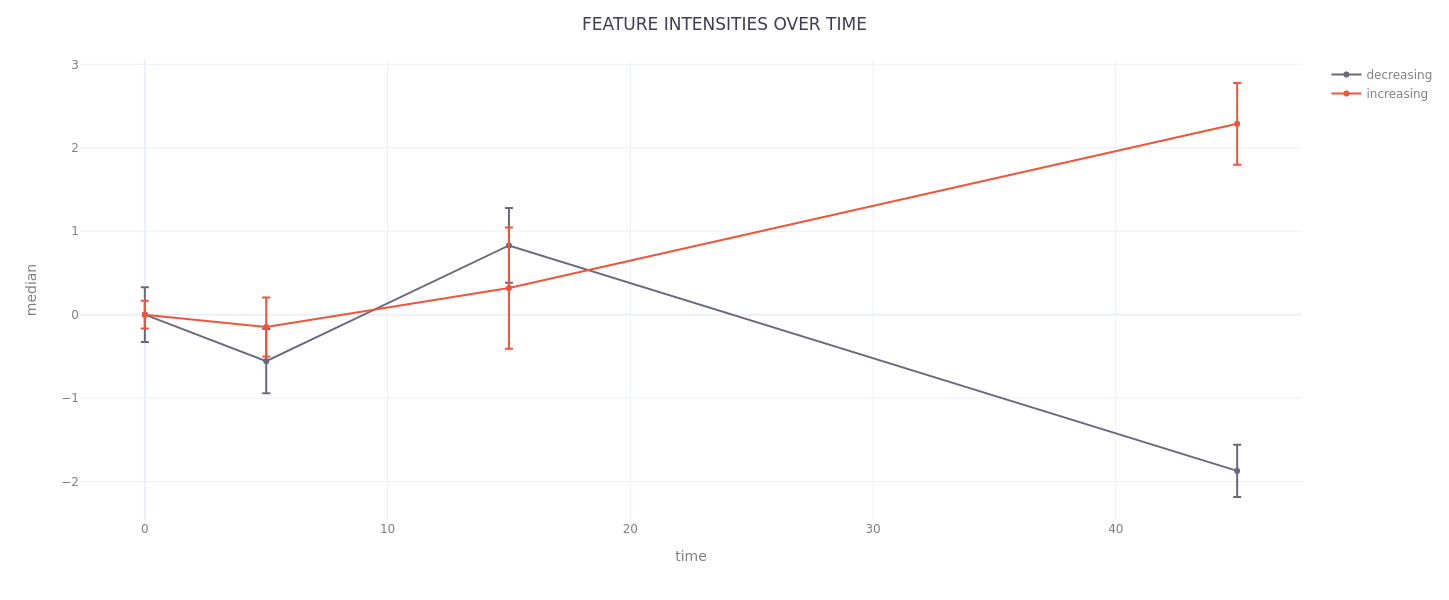

In [117]:
# get only significant metabolites from the scales data
significant_metabolites = data[anova[anova['significant']]['metabolite']]
# add time point information to grouby
significant_metabolites.insert(0, 'ATTRIBUTE_Time-Point', data['ATTRIBUTE_Time-Point'])
# get a dataframe for each time point
time_groups = significant_metabolites.groupby('ATTRIBUTE_Time-Point')

# since we have multiple entries for each time point get them as set (single values)
time_points = sorted(set(data['ATTRIBUTE_Time-Point']))

# classify metabolites as increasing or decreasing over time
decreasing = []
increasing = []
for metabolite in anova[anova['significant']]['metabolite']:
    mean_zero = time_groups.get_group(time_points[0])[metabolite].mean()
    mean_last = time_groups.get_group(time_points[-1])[metabolite].mean()
    if mean_zero < mean_last:
        increasing.append(metabolite)
    else:
        decreasing.append(metabolite)

# create figure
fig = px.scatter(template='plotly_white', width=600, height=600)

# plot decreasing values
mean = [time_groups.get_group(time_point)[decreasing].mean().median() for time_point in time_points]
mean = [x-mean[0] for x in mean] # adjust to baseline (timepoint 0)
error = [time_groups.get_group(time_point)[decreasing].mean().std() for time_point in time_points]
fig.add_trace(go.Scatter(x=time_points, y=mean, marker_color='#696880', error_y={'array': error}, name='decreasing'))

# plot increasing values
mean = [time_groups.get_group(time_point)[increasing].mean().median() for time_point in time_points]
mean = [x-mean[0] for x in mean] # adjust to baseline (timepoint 0)
error = [time_groups.get_group(time_point)[increasing].mean().std() for time_point in time_points]
fig.add_trace(go.Scatter(x=time_points, y=mean, marker_color='#ef553b', error_y={'array': error}, name='increasing'))

fig.update_layout(font={"color":"grey", "size":12, "family":"Sans"},
                  title={"text":"FEATURE INTENSITIES OVER TIME", 'x':0.5, "font_color":"#3E3D53"},
                  xaxis_title="time", yaxis_title="median")

# save fig as pdf
fig.write_image(os.path.join(result_dir, "plot_Dilution_Series.pdf"), scale=3)

fig.show()

**Tukey's post hoc test:**

Features with both positive and negative time trends exist, but differences appear to the be largest between timepoint 0 and 45. Tukey's post hoc test can be used to calculate which features show statistically significant differences between these two timepoints.

In [86]:
def gen_pairwise_tukey(df, time_points, metabolites):
    """ Yield results for pairwise Tukey test for all metabolites between start and end time points."""
    for metabolite in metabolites:
        df_for_tukey = df.iloc[np.where(data['ATTRIBUTE_Time-Point'].isin([time_points[0], time_points[-1]]))][[metabolite, 'ATTRIBUTE_Time-Point']]
        tukey = pg.pairwise_tukey(df_for_tukey, dv=metabolite, between='ATTRIBUTE_Time-Point')
        yield metabolite, int(metabolite.split('_')[0]), tukey['diff'], tukey['p-tukey']

dtypes = [('stats_metabolite', 'U100'), ('stats_ID', 'i'), ('stats_diff', 'f'), ('stats_p', 'f')]
tukey = pd.DataFrame(np.fromiter(gen_pairwise_tukey(data, time_points, anova[anova['significant']]['metabolite']), dtype=dtypes))
# add Bonferroni corrected p-values
tukey.insert(4, 'stats_p_bonferroni', pg.multicomp(tukey['stats_p'], method='bonf')[1])
# add significance
tukey.insert(5, 'stats_significant', tukey['stats_p_bonferroni'] < 0.05)
# sort by p-value
tukey.sort_values('stats_p', inplace=True)

# write output to csv file
tukey.to_csv(os.path.join(result_dir, 'TukeyHSD_output.csv'))

display(tukey)

,stats_metabolite,stats_ID,stats_diff,stats_p,stats_p_bonferroni,stats_significant
0,9299_191.143_6.686,9299,-2.364702,9.084435e-10,5.695941e-07,True
3,15262_329.269_9.565,15262,-2.313956,4.860331e-09,3.047428e-06,True
15,2529_224.151_4.234,2529,2.703355,7.331098e-09,4.596599e-06,True
459,14762_269.175_9.204,14762,2.265141,1.336012e-08,8.376795e-06,True
7,2123_212.118_3.936,2123,-2.301754,1.692223e-08,1.061024e-05,True
...,...,...,...,...,...,...
531,7123_232.154_5.994,7123,0.174835,4.177927e-01,1.000000e+00,False
396,16068_390.322_10.281,16068,0.127616,4.394811e-01,1.000000e+00,False
483,16710_343.267_11.266,16710,0.121254,6.301997e-01,1.000000e+00,False
356,7926_215.128_6.247,7926,0.086644,6.752428e-01,1.000000e+00,False


Create a volcano plot that displays -log(p) on the y-axis and group-difference on the x-axis. Again, display names of top findings in the plot

Create a volcano plot that displays -log(p) on the y-axis and group-difference on the x-axis. Again, display names of top findings in the plot

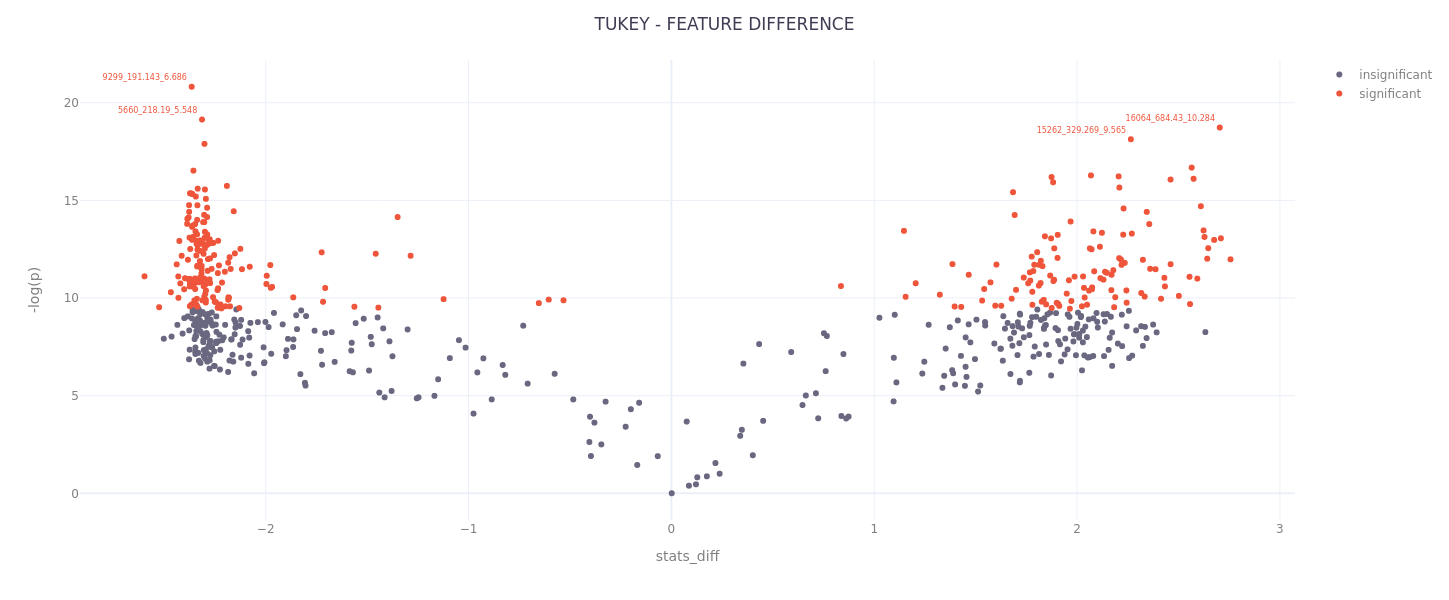

In [88]:
# create figure
fig = px.scatter(template='plotly_white', width=600, height=600)

# plot insignificant values
fig.add_trace(go.Scatter(x=tukey[tukey['stats_significant'] == False]['stats_diff'],
                         y=tukey[tukey['stats_significant'] == False]['stats_p'].apply(lambda x: -np.log(x)),
                         mode='markers', marker_color='#696880', name='insignificant'))

# plot significant values
fig.add_trace(go.Scatter(x=tukey[tukey['stats_significant']]['stats_diff'],
                         y=tukey[tukey['stats_significant']]['stats_p'].apply(lambda x: -np.log(x)),
                         mode='markers+text', text=anova['metabolite'].iloc[:4], textposition='top left', 
                         textfont=dict(color='#ef553b', size=8), marker_color='#ef553b', name='significant'))

fig.update_layout(font={"color":"grey", "size":12, "family":"Sans"},
                  title={"text":"TUKEY - FEATURE DIFFERENCE", 'x':0.5, "font_color":"#3E3D53"},
                  xaxis_title="stats_diff", yaxis_title="-log(p)")

# save image as pdf
fig.write_image(os.path.join(result_dir, "TukeyHSD_group0vsgroup45.pdf"), scale=3)

fig.show()

As a sanity check we can check a few of the top metabolites by plotting them in a boxplot. Just change the input argument for y to match a name in the result list above.

In [116]:
def metabolite_boxplot(metabolite):
    p_value = anova.set_index('metabolite')._get_value(metabolite, "p")
    df = data[['ATTRIBUTE_Time-Point', metabolite]]
    title = str(metabolite)+"<br>p-value:"+str(p_value)
    fig = px.box(df, x='ATTRIBUTE_Time-Point', y=metabolite, template='plotly_white',
                 width=800, height=600, points='all', color='ATTRIBUTE_Time-Point')

    fig.update_layout(font={"color":"grey", "size":12, "family":"Sans"},
                      title={"text":title, 'x':0.5, "font_color":"#3E3D53"},
                      xaxis_title="time point", yaxis_title="intensity scales and centered")
    fig.show()
    return None

# Add dropdown to create boxplot of metabolite selected (just for significant=True)
interact(metabolite_boxplot, metabolite=sorted(list(anova["metabolite"][anova["significant"]==True])))

interactive(children=(Dropdown(description='metabolite', options=('10118_247.154_6.951', '10166_288.181_6.967'…

<function __main__.metabolite_boxplot(metabolite)>

# PCoA PermANOVA:

Principal coordinates analysis (PCoA)

Principal coordinates analysis (PCoA) is a metric multidimensional scaling (MDS) method that attempts to represent sample dissimilarities in a low-dimensional space. It converts a distance matrix consisting of pair-wise distances (dissimilarities) across samples into a 2- or 3-D graph (Gower, 2005). Different distance metrics can be used to calculate dissimilarities among samples (e.g. Euclidean, Canberra, Minkowski). Performing a principal coordinates analysis using the Euclidean distance metric is the same as performing a principal components analysis (PCA). The selection of the most appropriate metric depends on the nature of your data and assumptions made by the metric.

Within the metabolomics field the Euclidean, Bray-Curtis, Jaccard or Canberra distances are most commonly used. The Jaccard distance is an unweighted metric (presence/absence) whereas Euclidean, Bray-Curtis and Canberra distances take into account relative abundances (weighted). Some metrics may be better suited for very sparse data (with many zeroes) than others. For example, the Euclidean distance metric is not recommended to be used for highly sparse data.

This video tutorial by StatQuest summarizes nicely the basic principles of PCoA: https://www.youtube.com/watch?v=GEn-_dAyYME

In order to perform a PCoA as described below, it is important that the filenames in our metadata are identical as well as in the same order as the filenames in our feature table. Let's make sure this is true, using the below code (this should return TRUE).

# Hierarchial Clustering Algorithm:

We are now ready to perform a cluter analysis. The concept behind hierarchical clustering is to repeatedly combine the two nearest clusters into a larger cluster.

The first step consists of calculating the distance between every pair of observation points and stores it in a matrix;
1. It puts every point in its own cluster;
2. It merges the closest pairs of points according to their distances;
3. It recomputes the distance between the new cluster and the old ones and stores them in a new distance matrix;
4. It repeats steps 2 and 3 until all the clusters are merged into one single cluster. <br>

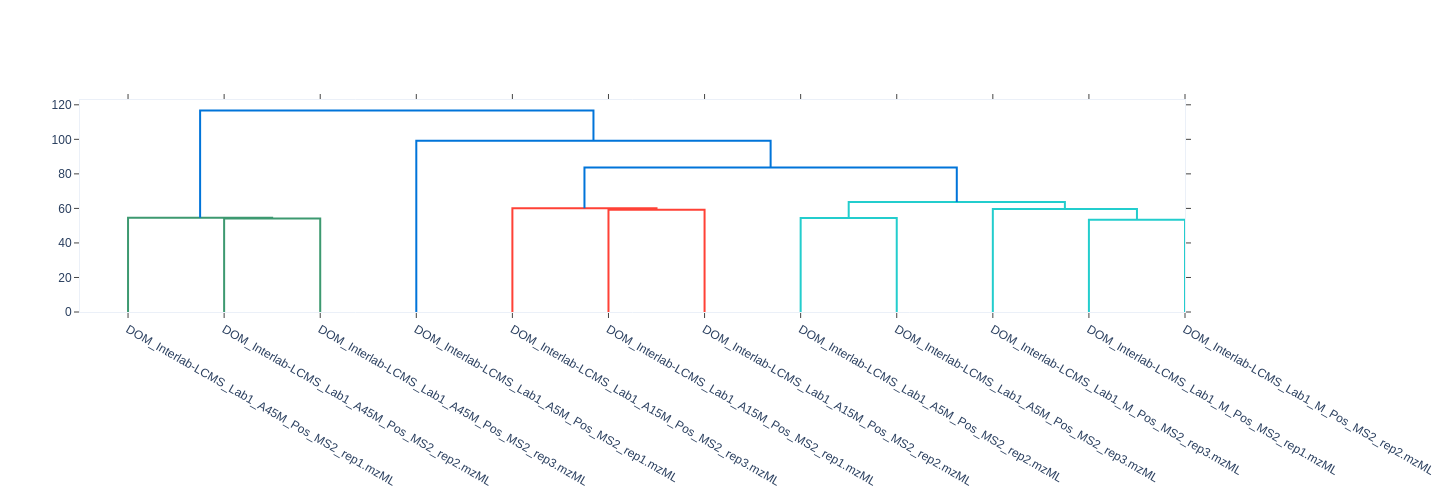

In [113]:
fig = ff.create_dendrogram(data_scaled, labels=list(data_scaled.index))
fig.update_layout(width=700, height=500, template='plotly_white')

# save image as pdf
fig.write_image(os.path.join(result_dir, "Cluster_Dendrogram.pdf"), scale=3)

fig.show()

In [109]:
# SORT DATA TO CREATE HEATMAP

# Compute linkage matrix from distances for hierarchical clustering
linkage_data_ft = linkage(data_scaled, method='complete', metric='euclidean')
linkage_data_samples = linkage(data_scaled.T, method='complete', metric='euclidean')

# Create a dictionary of data structures computed to render the dendrogram. 
# We will use dict['leaves']
cluster_samples = dendrogram(linkage_data_ft, no_plot=True)
cluster_ft = dendrogram(linkage_data_samples, no_plot=True)

# Create dataframe with sorted samples
ord_samp = data_scaled.copy()
ord_samp.reset_index(inplace=True)
ord_samp = ord_samp.reindex(cluster_samples['leaves'])
ord_samp.rename(columns={'index': 'Filename'}, inplace=True)
ord_samp.set_index('Filename', inplace=True)

# Create dataframe with sorted features
ord_ft = ord_samp.T.reset_index()
ord_ft = ord_ft.reindex(cluster_ft['leaves'])
ord_ft.rename(columns={'index': 'Feature'}, inplace=True)
ord_ft.set_index('Feature', inplace=True)

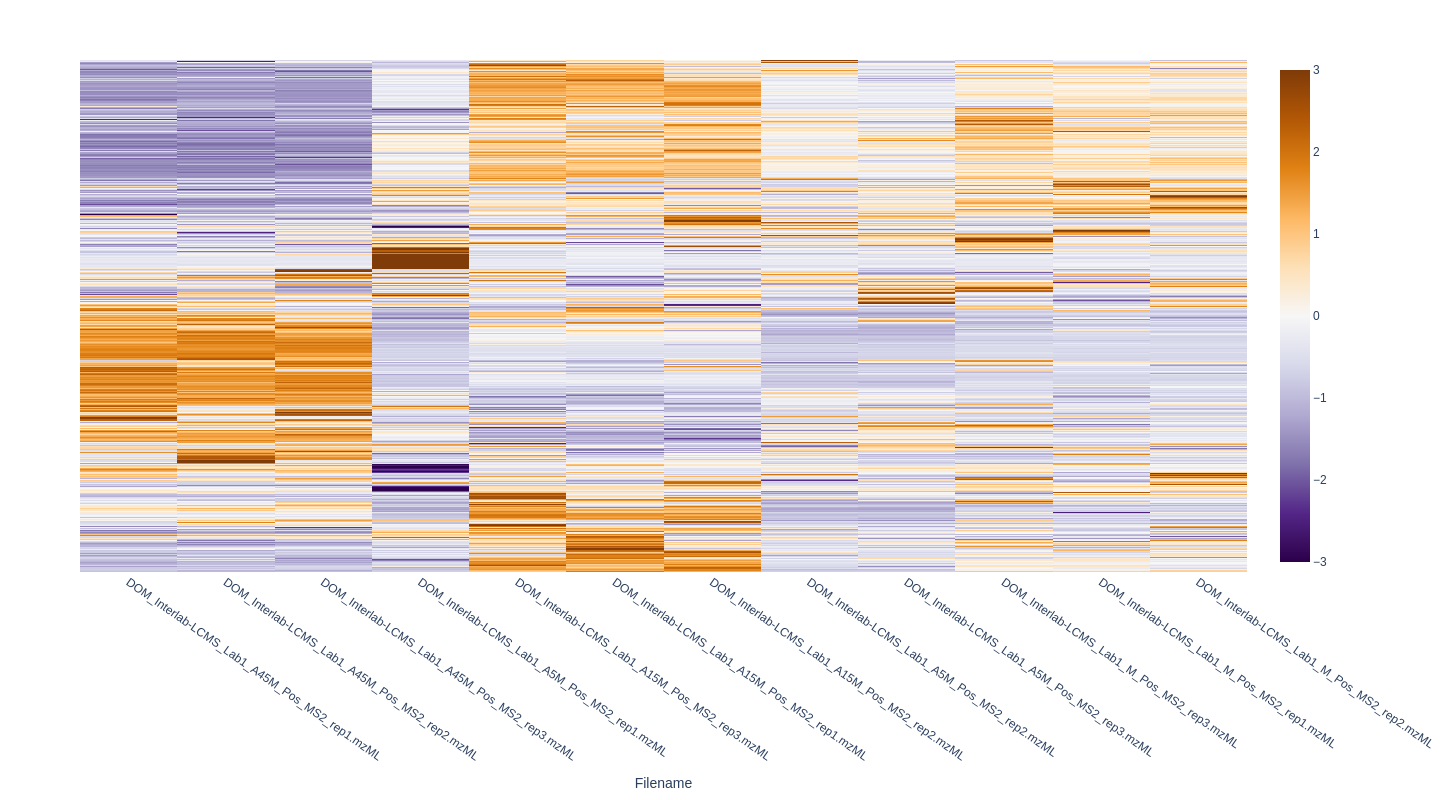

In [115]:
#Heatmap
fig = px.imshow(ord_df,y=list(ord_ft.index), x=list(ord_ft.columns), text_auto=True, aspect="auto",
               color_continuous_scale='PuOr_r', range_color=[-3,3])

fig.update_layout(
    autosize=False,
    width=700,
    height=800)

fig.update_yaxes(visible=False)
fig.update_xaxes(tickangle = 35)

# save image as pdf
fig.write_image(os.path.join(result_dir, "Heatmap.pdf"), scale=3)

fig.show()